### Instal and import relevant libraries 

In [1]:
# !pip install xgboost
# ! pip install lightgbm


In [5]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
import xgboost as xgb

### Load the datasets 

In [4]:
train_df = pd.read_csv("train.csv", index_col='patient_id')
test_df = pd.read_csv("test.csv", index_col='patient_id')
sub_df  = pd.read_csv("solution_template.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'solution_template.csv'

In [7]:
# In below code I define a custome color map and I will be using this color map in some coming viualizatoins

# Define the colors for the palette (sky blue to purple)
colors = ['#86CEEB', '#ACD8E7', '#D3DAE1', '#C59BF4', '#A96AEB']

# Reverse the colors
# colors_reversed = colors[::-1]

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

### Data Preprocessing

In [8]:
# Display a summary of a DataFrame, including the index dtype and column dtypes, non-null values, and memory usage
train_df.info()
print("\n ........................................ \n")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13173 entries, 268700 to 379418
Columns: 151 entries, patient_race to metastatic_diagnosis_period
dtypes: float64(137), int64(3), object(11)
memory usage: 15.3+ MB

 ........................................ 

<class 'pandas.core.frame.DataFrame'>
Index: 5646 entries, 730681 to 873886
Columns: 150 entries, patient_race to Average of Dec-18
dtypes: float64(137), int64(2), object(11)
memory usage: 6.5+ MB


In [9]:
# Get the dimensions of the DataFrame as a tuple (number of rows, number of columns)

print("Train Data:",train_df.shape)
print("Test Data:", test_df.shape)

Train Data: (13173, 151)
Test Data: (5646, 150)


In [10]:
# show first few rows 
train_df.head()

,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
patient_id,,,,,,,,,,,,,,,,,,,,,
268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,C50912,...,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,C50412,...,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71,33
277055,NaN,COMMERCIAL,CA,925,West,Pacific,59,F,NaN,1749,...,68.50,70.31,78.61,87.24,85.52,80.75,70.81,62.67,55.58,157
320055,Hispanic,MEDICAID,CA,900,West,Pacific,59,F,NaN,C50911,...,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46,146
190386,NaN,COMMERCIAL,CA,934,West,Pacific,71,F,NaN,1748,...,59.45,60.24,64.77,69.81,70.13,68.10,65.38,60.72,54.08,286


In [11]:
# Show last few rows 
train_df.tail()

,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
patient_id,,,,,,,,,,,,,,,,,,,,,
588544,Hispanic,MEDICAID,PA,191,Northeast,Middle Atlantic,59,F,NaN,C50911,...,48.81,66.12,70.38,77.18,77.53,70.90,56.53,41.46,37.49,106
393047,NaN,COMMERCIAL,TX,757,South,West South Central,73,F,30.67,1749,...,62.03,77.82,84.52,85.35,84.61,78.50,67.24,52.16,50.01,92
790904,NaN,COMMERCIAL,CA,928,West,Pacific,19,F,NaN,C50819,...,66.20,66.04,70.87,80.68,79.75,75.27,71.40,66.01,59.20,0
455518,NaN,COMMERCIAL,MI,481,Midwest,East North Central,52,F,NaN,1742,...,39.93,63.56,68.68,72.13,72.55,66.17,49.79,34.16,32.28,330
379418,Hispanic,MEDICAID,CA,900,West,Pacific,63,F,NaN,C50911,...,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46,0


In [12]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

# Display the column names
train_df.columns.tolist()

['patient_race',
 'payer_type',
 'patient_state',
 'patient_zip3',
 'Region',
 'Division',
 'patient_age',
 'patient_gender',
 'bmi',
 'breast_cancer_diagnosis_code',
 'breast_cancer_diagnosis_desc',
 'metastatic_cancer_diagnosis_code',
 'metastatic_first_novel_treatment',
 'metastatic_first_novel_treatment_type',
 'population',
 'density',
 'age_median',
 'age_under_10',
 'age_10_to_19',
 'age_20s',
 'age_30s',
 'age_40s',
 'age_50s',
 'age_60s',
 'age_70s',
 'age_over_80',
 'male',
 'female',
 'married',
 'divorced',
 'never_married',
 'widowed',
 'family_size',
 'family_dual_income',
 'income_household_median',
 'income_household_under_5',
 'income_household_5_to_10',
 'income_household_10_to_15',
 'income_household_15_to_20',
 'income_household_20_to_25',
 'income_household_25_to_35',
 'income_household_35_to_50',
 'income_household_50_to_75',
 'income_household_75_to_100',
 'income_household_100_to_150',
 'income_household_150_over',
 'income_household_six_figure',
 'income_indivi

In [13]:
# Select only the columns with object (string) or categorical dtype
categorical_columns = train_df.select_dtypes(include=['object', 'category']).columns

print("Categorical columns:")
print(categorical_columns)

Categorical columns:
Index(['patient_race', 'payer_type', 'patient_state', 'Region', 'Division',
       'patient_gender', 'breast_cancer_diagnosis_code',
       'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code',
       'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type'],
      dtype='object')


In [14]:
# Calculate the number of columns containing null values in the train dataset
num_null_columns = train_df.isnull().any().sum()
print(num_null_columns, "Columns contain null values in the Train dataset \n")

# Calculate the number of columns containing null values in the test dataset
num_null_columns = test_df.isnull().any().sum()
print(num_null_columns, "Columns contain null values in the Test dataset")

72 Columns contain null values in the Train dataset 

44 Columns contain null values in the Test dataset


In [15]:
# Create a DataFrame to summarize null values, data types, and unique values in train_df and test_df
null_data = pd.DataFrame({
    'type': train_df.dtypes,                         
    'count_train': train_df.count(),                 
    'null_train': train_df.isnull().sum(),           
    '%null_train': train_df.isnull().mean() * 100,   
    'unique_train': train_df.nunique(),              
    'count_test': test_df.count(),                   
    '%null_test': test_df.isnull().mean() * 100,     
    'unique_test': test_df.nunique(),                

}).sort_values(by=['type', 'null_train'], ascending=False) 

# Set display option to show all rows
pd.set_option('display.max_rows', None)

# Display the entire DataFrame 
display(null_data)

,type,count_train,null_train,%null_train,unique_train,count_test,%null_test,unique_test
metastatic_first_novel_treatment,object,11,13162,99.916496,2,7.0,99.876018,2.0
metastatic_first_novel_treatment_type,object,11,13162,99.916496,1,7.0,99.876018,1.0
patient_race,object,6516,6657,50.535186,5,2861.0,49.326957,5.0
payer_type,object,11408,1765,13.398618,3,4861.0,13.903649,3.0
Division,object,13173,0,0.000000,8,5646.0,0.000000,8.0
Region,object,13173,0,0.000000,4,5646.0,0.000000,4.0
breast_cancer_diagnosis_code,object,13173,0,0.000000,47,5646.0,0.000000,41.0
breast_cancer_diagnosis_desc,object,13173,0,0.000000,47,5646.0,0.000000,41.0
metastatic_cancer_diagnosis_code,object,13173,0,0.000000,43,5646.0,0.000000,38.0
patient_gender,object,13173,0,0.000000,1,5646.0,0.000000,1.0


### Findings and Actions: ###

**Columns with Null Values:**
- 72 out of 151 columns in `train_df` contain null values, and 44 out of 151 columns in `test_df` contain null values.

Action:
- We will drop the two columns `metastatic_first_novel_treatment` and `metastatic_first_novel_treatment_type`, which have 99.9% null values in both train and test datasets.

- `patient_race` has 50.5% nulls. We'll write and apply a function to fill the nulls with the most frequent value (mode) at the zip and state levels. If no mode is available, it will fill the nulls with 'Other'.

- `Payer_type` has 13% null values; we will rename the null values as "Not Specified" for clarity.

- `bmi` contains 68.8% null values in `train_df` and 69.8% in `test_df`; becuase we think it is an important column, so we will use KNN imputation to fill the nulls. 

- Temperature Columns (Average Temperatures): the null values are not significant (<1.5%), so we will utilize forward filling to address them.

- Other Columns with Few Nulls (<5), the columns we will use for prediction, which have 5 or fewer missing values, will be handled by imputation techniques such as mean, median, or mode to fill null values.

**Unique Values:**
- `patient_gender` has only one unique value.

Action:
- We will drop `patient_gender` as it does not provide meaningful variation.

**Categorical Variables:**
- There are 11 categorical columns (object data type) in the dataset. 

Action:
- We will convert categorical variables as necessary into a numerical format using Label Encoding or One-Hot Encoding so that machine learning algorithms can understand. 


**Note:** We will apply identified actions (dropping, renaming, imputation) consistently to both `train_df` and `test_df` for data integrity and model readiness.

**Dropping Columns**
- metastatic_first_novel_treatment
- metastatic_first_novel_treatment_type
- patient_gender

In [3]:
# Drop the mentioned columns from train_df
train_df = train_df.drop(columns=['metastatic_first_novel_treatment', 
                                  'metastatic_first_novel_treatment_type',
                                  'patient_gender'])

# Drop the mentioned columns from test_df
test_df = test_df.drop(columns=['metastatic_first_novel_treatment',
                                 'metastatic_first_novel_treatment_type',
                                 'patient_gender'])

print(train_df.shape, "\n", test_df.shape)

(13173, 148) 
 (5646, 147)


**Filling missing values in tempreture related columns**

In [4]:
# filling tempreture missing values in both train and test datasets 

# Identify temperature-related columns in train dataset 
tr_temp_columns = [col for col in train_df.columns if 'Average of ' in col]

# Forward fill the missing values in the train_df
train_df[tr_temp_columns] = train_df[tr_temp_columns].ffill(axis=0)


# Identify temperature-related columns in test dataset 
ts_temp_columns = [col for col in test_df.columns if 'Average of ' in col]

# Forward fill the missing values in the test_df
test_df[ts_temp_columns] = test_df[ts_temp_columns].ffill(axis=0)

**Filling missing values in payer_type column**

In [5]:
# Rename null values in payer_type as "Unspecified" in both train and test datasets 
train_df['payer_type'] = train_df['payer_type'].fillna("NOT SPECIFIED")
test_df['payer_type'] = test_df['payer_type'].fillna("NOT SPECIFIED")

print("Nulls in payer_type in train_df: ", train_df['payer_type'].isnull().sum(),"\n") 
print("Nulls in payer_type in test_df: ", test_df['payer_type'].isnull().sum()) 

Nulls in payer_type in train_df:  0 

Nulls in payer_type in test_df:  0


**Filling missing values in income related columns**
- income_household_under_5
- income_household_median
- income_household_six_figure

In [6]:
# Fill missing values with the median of each column
train_df['income_household_under_5'] = train_df['income_household_under_5'].fillna(train_df['income_household_under_5'].median())

train_df['income_household_median'] = train_df['income_household_median'].fillna(train_df['income_household_median'].median())

train_df['income_household_six_figure'] = train_df['income_household_six_figure'].fillna(train_df['income_household_six_figure'].median())

**Filling missing values in patient_race column**

In [7]:
# Function to fill missing values based on mode within each group
def fill_mode(series):
    mode = series.mode()
    if not mode.empty:
        return series.fillna(mode[0])
    return series.fillna('Unknown')

# Function to apply both groupings(at zip and state levle)
def combined_imputation(df):
    # Impute by patient_zip3
    df['patient_race'] = df.groupby('patient_zip3')['patient_race'].transform(fill_mode)
    # Impute by patient_state
    df['patient_race'] = df.groupby('patient_state')['patient_race'].transform(fill_mode)
    # Fill any remaining NaN or 'Unknown' values with a default value, e.g., 'Other'
    df['patient_race'] = df['patient_race'].replace('Unknown', np.nan).fillna('Other')
    return df

# Apply the combined imputation function on train_df 
train_df = combined_imputation(train_df)

# Apply the combined imputation function on test_df 
test_df = combined_imputation(test_df)

In [22]:
# Check for null values in patient_race and payer_type columns in train_df and test_df
print("Nulls in patient_race in train_df: ", train_df['patient_race'].isnull().sum(),"\n") 
print("Nulls in patient_race in test_df: ", test_df['patient_race'].isnull().sum(),"\n") 

# Show first few rows of the two dataframes 
print(train_df['patient_race'].head(),'\n')
print(test_df['patient_race'].head(),'\n')

Nulls in patient_race in train_df:  0 

Nulls in patient_race in test_df:  0 

patient_id
268700       Other
484983       White
277055       White
320055    Hispanic
190386       White
Name: patient_race, dtype: object 

patient_id
730681       Black
334212       Black
571362    Hispanic
907331       White
208382       Asian
Name: patient_race, dtype: object 



**Filling missing values in bmi column**

In [8]:
# Select columns for KNN imputation
columns_for_imputation = ['bmi', 'patient_age', 'income_individual_median', 'poverty']

# Create the KNN imputer with n_neighbors=5
imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputer to fill missing values in bmi column
train_df[columns_for_imputation] = imputer.fit_transform(train_df[columns_for_imputation])

**Converting categorical variable to numerical**
- patient_race
- payer_type
- Region
- patient_state
- breast_cancer_diagnosis_code
- metastatic_cancer_diagnosis_code

In [8]:
# Initialize label encoders for each column
label_encoder_PR = LabelEncoder()
label_encoder_PT = LabelEncoder()
label_encoder_R = LabelEncoder()
label_encoder_S = LabelEncoder()
label_encoder_BCDC = LabelEncoder()
label_encoder_MCDC = LabelEncoder()


# Fit the label encoders on the training data
label_encoder_PT.fit(train_df['payer_type'])
label_encoder_PR.fit(train_df['patient_race'])
label_encoder_R.fit(train_df['Region'])
label_encoder_S.fit(train_df['patient_state'])
label_encoder_BCDC.fit(train_df['breast_cancer_diagnosis_code'])
label_encoder_MCDC.fit(train_df['metastatic_cancer_diagnosis_code'])

# Transform the columns in train_df 
train_df['patient_race_encoded'] = label_encoder_PR.transform(train_df['patient_race'])
train_df['payer_type_encoded'] = label_encoder_PT.transform(train_df['payer_type'])
train_df['Region_encoded'] = label_encoder_R.transform(train_df['Region'])
train_df['patient_state_encoded'] = label_encoder_S.transform(train_df['patient_state'])
train_df['bcdc_encoded'] = label_encoder_BCDC.transform(train_df['breast_cancer_diagnosis_code'])
train_df['mcdc_encoded'] = label_encoder_MCDC.transform(train_df['metastatic_cancer_diagnosis_code'])


# Transform the columns in test_df 
test_df['patient_race_encoded'] = label_encoder_PR.transform(test_df['patient_race'])
test_df['payer_type_encoded'] = label_encoder_PT.transform(test_df['payer_type'])
test_df['Region_encoded'] = label_encoder_R.transform(test_df['Region'])
test_df['patient_state_encoded'] = label_encoder_S.transform(test_df['patient_state'])



# There are unseen values in the 'breast_cancer_diagnosis_code' and 'metastatic_cancer_diagnosis_code' in test_df 

# Create mappings of the original classes to their labels
class_mapping_bcdc = {cls: idx for idx, cls in enumerate(label_encoder_BCDC.classes_)}
class_mapping_mcdc = {cls: idx for idx, cls in enumerate(label_encoder_MCDC.classes_)}


# Define a function to transform with handling for unseen values
def transform_with_unseen_values(series, mapping, unseen_value=-1):
    return series.map(mapping).fillna(unseen_value).astype(int)

# Apply the function on 'breast_cancer_diagnosis_code, and 'metastatic_cancer_diagnosis_code' in test_df
test_df['bcdc_encoded'] = transform_with_unseen_values(test_df['breast_cancer_diagnosis_code'], class_mapping_bcdc)
test_df['mcdc_encoded'] = transform_with_unseen_values(test_df['metastatic_cancer_diagnosis_code'], class_mapping_mcdc)

# Columns to drop
# columns_to_drop = ['Region', 'breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code']

# Drop columns from train_df
# train_df = train_df.drop(columns=columns_to_drop)

# Drop columns from test_df
# test_df = test_df.drop(columns=columns_to_drop)


# Show few rows of train_df 
train_df.head()


,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period,patient_race_encoded,payer_type_encoded,Region_encoded,patient_state_encoded,bcdc_encoded,mcdc_encoded
patient_id,,,,,,,,,,,,,,,,,,,,,
268700,Other,COMMERCIAL,AR,724,South,West South Central,39,NaN,C50912,Malignant neoplasm of unspecified site of left...,...,59.98,42.98,41.18,191,3,0,2,2,44,3
484983,White,NOT SPECIFIED,IL,629,Midwest,East North Central,55,35.36,C50412,Malig neoplasm of upper-outer quadrant of left...,...,58.36,39.68,39.71,33,4,3,0,13,28,3
277055,White,COMMERCIAL,CA,925,West,Pacific,59,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,70.81,62.67,55.58,157,4,0,3,4,7,3
320055,Hispanic,MEDICAID,CA,900,West,Pacific,59,NaN,C50911,Malignant neoplasm of unsp site of right femal...,...,68.95,65.46,59.46,146,2,1,3,4,43,3
190386,White,COMMERCIAL,CA,934,West,Pacific,71,NaN,1748,Malignant neoplasm of other specified sites of...,...,65.38,60.72,54.08,286,4,0,3,4,6,30


### Exploratory Data Analysis (EDA)

In [26]:
# Generate descriptive statistics for numerical columns of the DataFrame
train_df.describe()

,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,age_50s,age_60s,age_70s,age_over_80,male,female,married,divorced,never_married,widowed,family_size,family_dual_income,income_household_median,income_household_under_5,income_household_5_to_10,income_household_10_to_15,income_household_15_to_20,income_household_20_to_25,income_household_25_to_35,income_household_35_to_50,income_household_50_to_75,income_household_75_to_100,income_household_100_to_150,income_household_150_over,income_household_six_figure,income_individual_median,home_ownership,housing_units,home_value,rent_median,rent_burden,education_less_highschool,education_highschool,education_some_college,education_bachelors,education_graduate,education_college_or_above,education_stem_degree,labor_force_participation,unemployment_rate,self_employed,farmer,race_white,race_black,race_asian,race_native,race_pacific,race_other,race_multiple,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Average of Jan-13,Average of Feb-13,Average of Mar-13,Average of Apr-13,Average of May-13,Average of Jun-13,Average of Jul-13,Average of Aug-13,Average of Sep-13,Average of Oct-13,Average of Nov-13,Average of Dec-13,Average of Jan-14,Average of Feb-14,Average of Mar-14,Average of Apr-14,Average of May-14,Average of Jun-14,Average of Jul-14,Average of Aug-14,Average of Sep-14,Average of Oct-14,Average of Nov-14,Average of Dec-14,Average of Jan-15,Average of Feb-15,Average of Mar-15,Average of Apr-15,Average of May-15,Average of Jun-15,Average of Jul-15,Average of Aug-15,Average of Sep-15,Average of Oct-15,Average of Nov-15,Average of Dec-15,Average of Jan-16,Average of Feb-16,Average of Mar-16,Average of Apr-16,Average of May-16,Average of Jun-16,Average of Jul-16,Average of Aug-16,Average of Sep-16,Average of Oct-16,Average of Nov-16,Average of Dec-16,Average of Jan-17,Average of Feb-17,Average of Mar-17,Average of Apr-17,Average of May-17,Average of Jun-17,Average of Jul-17,Average of Aug-17,Average of Sep-17,Average of Oct-17,Average of Nov-17,Average of Dec-17,Average of Jan-18,Average of Feb-18,Average of Mar-18,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period,patient_race_encoded,payer_type_encoded,Region_encoded,patient_state_encoded,bcdc_encoded,mcdc_encoded
count,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13168.000000,13168.000000,13173.000000,13173.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13168.000000,13173.000000,13173.000000,13168.000000,13173.000000,1.316800e+04,13168.000000,13168.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13168.000000,13168.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13168.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,13173.000000,1317

**Distribution of Metastatic Diagnosis Period**

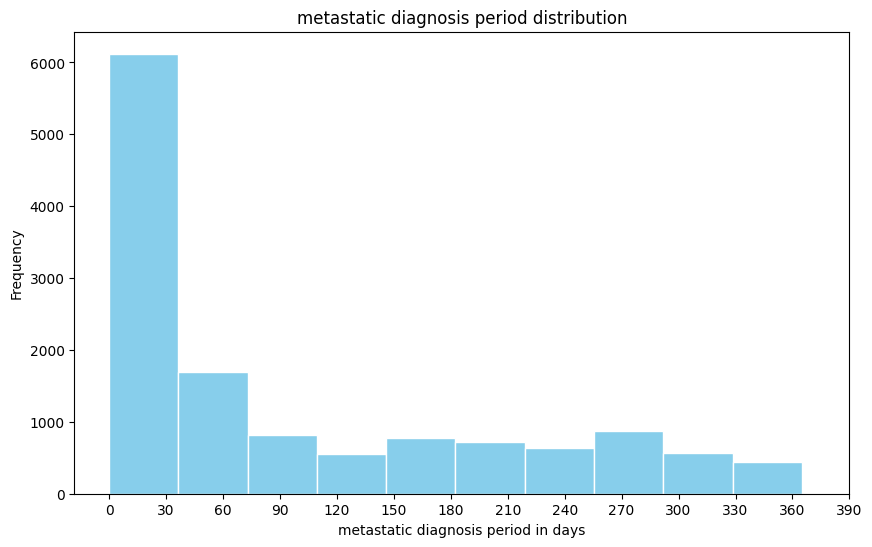

In [27]:
# Distribution of metastatic_diagnosis_period
plt.figure(figsize=(10, 6))
train_df['metastatic_diagnosis_period'].plot(kind='hist', color='SkyBlue', edgecolor='white')
plt.title('metastatic diagnosis period distribution')
plt.xlabel('metastatic diagnosis period in days')

max_value = train_df['metastatic_diagnosis_period'].max()
# Set x-axis ticks
plt.xticks(np.arange(0, max_value + 30, 30))

plt.show()

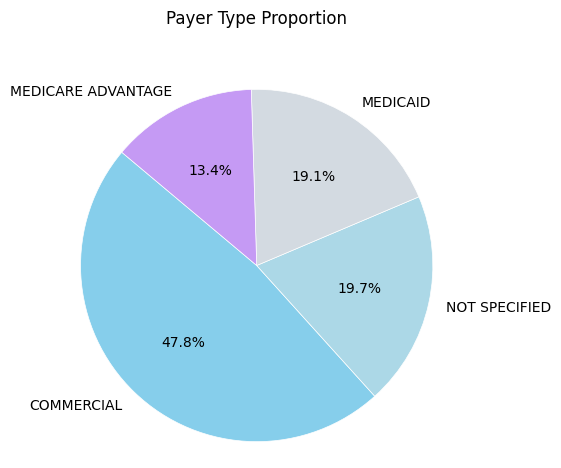

In [28]:
# Proportion of Pyer types 

# Prepare data
labels = train_df['payer_type'].unique()
sizes = train_df['payer_type'].value_counts()

# Generate colors from the colormap
num_colors = len(labels)
color_map = [custom_cmap(i / num_colors) for i in range(num_colors)]

# Create pie chart with custom colormap
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=color_map, 
        wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'})
plt.axis('equal')
plt.title('Payer Type Proportion\n\n')
plt.show()

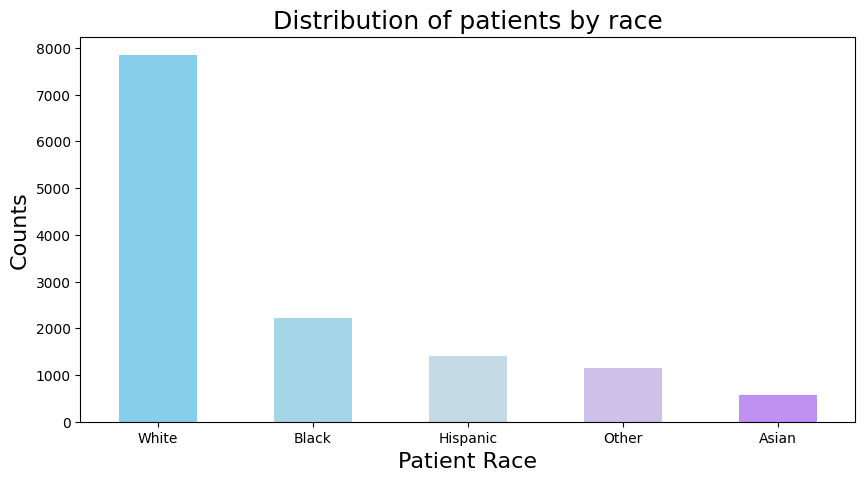

In [29]:
# Patients race distribution
plt.figure(figsize=(10, 5))
train_df['patient_race'].value_counts().plot(kind='bar', 
color=[custom_cmap(i / len(train_df['patient_race'].unique())) for i in range(len(train_df['patient_race'].unique()))])

plt.title("Distribution of patients by race", fontsize=18)
plt.xlabel('Patient Race', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.xticks(rotation=0)
plt.show()

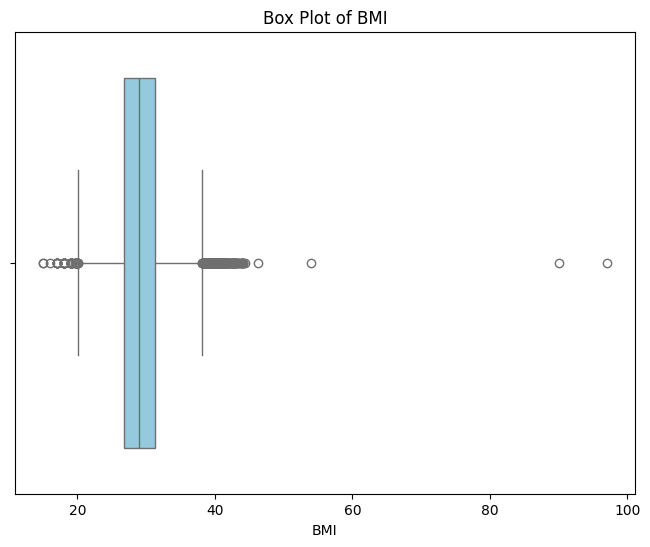

In [30]:
# Plotting box plot of BMI(body mass index)
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_df['bmi'], color='skyblue')
plt.title('Box Plot of BMI')
plt.xlabel('BMI')
plt.show()

In [31]:
print("Max age:", train_df['patient_age'].max())

print("Min age:", train_df['patient_age'].min())

Max age: 91.0
Min age: 18.0


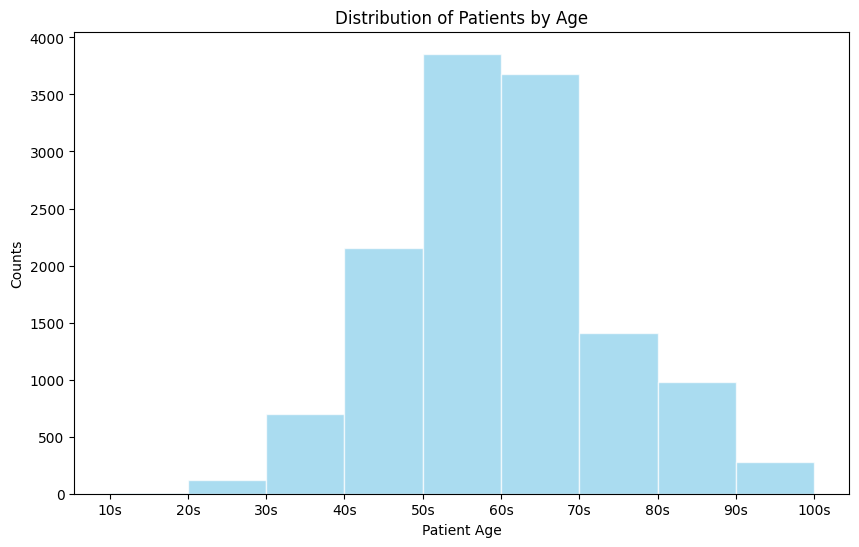

In [32]:
# Define equal-width bins for age groups. Here, age groups from 10 to 100 with a bin width of 10
bins = range(10, 101, 10)  

# Plot age distribution with equal-width bins
plt.figure(figsize=(10, 6))
train_df['patient_age'].plot(kind='hist', bins=bins, edgecolor='white', color='skyblue', alpha=0.7)

# Add title and labels
plt.title('Distribution of Patients by Age')
plt.xlabel('Patient Age')
plt.ylabel('Counts')

# Set custom x-axis labels
plt.xticks(ticks=bins, labels=['10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s'])

# Show plot
plt.show()

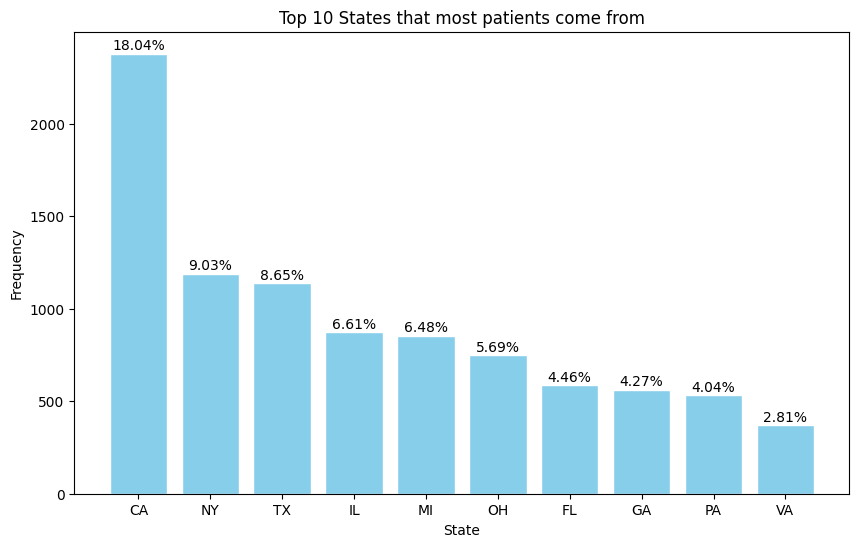

In [33]:
# Calculate frequency of each state
state_counts = train_df['patient_state'].value_counts()

# Select top 10 states
top_states = state_counts.head(10)

# Plot histogram of top 10 states
plt.figure(figsize=(10, 6))
bars = plt.bar(top_states.index, top_states.values, color='skyblue', edgecolor='white')

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f'{height / len(train_df) * 100:.2f}%', ha='center', va='bottom')

plt.title('Top 10 States that most patients come from')
plt.xlabel('State')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

### Feature Engineering and Feature Selection:

In [11]:
# Create a new column MDiagPeriod90D in train_df to represent whether the metastatic diagnosis period 
# is 90 days or less. assigns a value of 1 if the period is 90 days or less, and 0 otherwise.

train_df['MDiagPeriod90D'] = (train_df['metastatic_diagnosis_period'] <= 90).astype(int)

# To verify the results
print(train_df['MDiagPeriod90D'].head())
print(train_df['metastatic_diagnosis_period'].head())

patient_id
268700    0
484983    1
277055    0
320055    0
190386    0
Name: MDiagPeriod90D, dtype: int32
patient_id
268700    191
484983     33
277055    157
320055    146
190386    286
Name: metastatic_diagnosis_period, dtype: int64


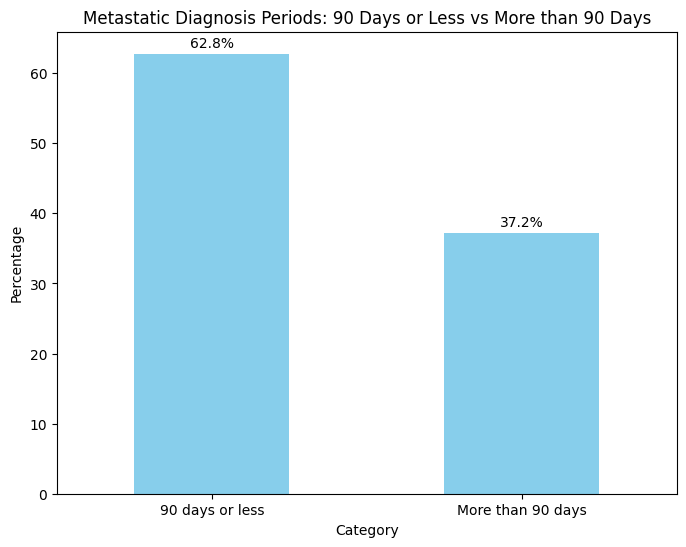

In [12]:
# Plot the counts of each category with percentage labels
plt.figure(figsize=(8, 6))
total = len(train_df['MDiagPeriod90D'])
percentages = train_df['MDiagPeriod90D'].value_counts() / total * 100
ax = percentages.plot(kind='bar', color='skyblue')

# Add percentage labels on top of each bar
for i, percentage in enumerate(percentages):
    plt.text(i, percentage + 0.5, f"{percentage:.1f}%", ha='center', va='bottom')

plt.title('Metastatic Diagnosis Periods: 90 Days or Less vs More than 90 Days')
plt.xlabel('Category')
plt.ylabel('Percentage')

# Add custom text to x-axis ticks
plt.xticks(ticks=[0, 1], labels=['90 days or less', 'More than 90 days'], rotation=0)

plt.show()

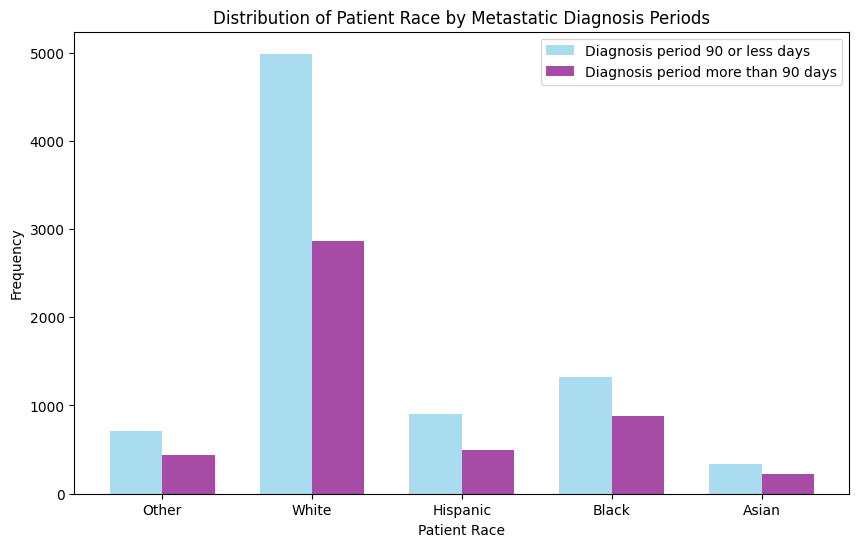

In [36]:
# Select data for each category 
category_0_data = train_df[train_df['MDiagPeriod90D'] == 0]['patient_race']
category_1_data = train_df[train_df['MDiagPeriod90D'] == 1]['patient_race']

# Get unique race categories
race_categories = train_df['patient_race'].unique()

# Define colors for categories 0 and 1
color_1 = 'skyblue'
color_0 = 'purple'

# Define the width of each bar
bar_width = 0.35

# Define the x positions for the bars
x = np.arange(len(race_categories))

# Plot both distributions on the same plot with different colors
plt.figure(figsize=(10, 6))

# Plot category 1 data
plt.bar(x - bar_width/2, [category_1_data[category_1_data == race].count() for race in race_categories], 
        width=bar_width, alpha=0.7, color=color_1, label='Diagnosis period 90 or less days')

# Plot category 0 data
plt.bar(x + bar_width/2, [category_0_data[category_0_data == race].count() for race in race_categories], 
        width=bar_width, alpha=0.7, color=color_0, label= 'Diagnosis period more than 90 days')

# Add labels and legend
plt.title('Distribution of Patient Race by Metastatic Diagnosis Periods')
plt.xlabel('Patient Race')
plt.ylabel('Frequency')
plt.xticks(x, race_categories)
plt.legend()

# Show the plot
plt.show()

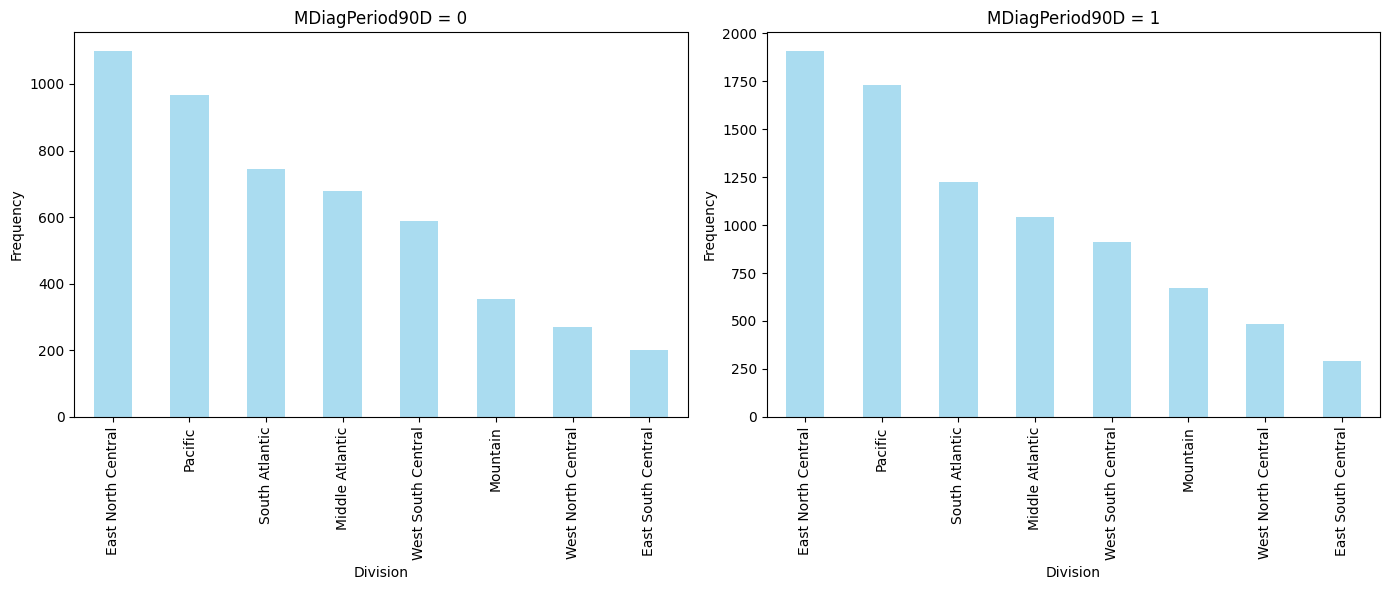

In [37]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Iterate over the categories (0 and 1)
for i, category in enumerate([0, 1]):
    # Select data based on the category
    data = train_df[train_df['MDiagPeriod90D'] == category]['Division']
    
    # Plot the distribution of data for the category
    data.value_counts().plot(kind='bar', ax=axes[i], color='skyblue', alpha=0.7)
    
    # Set title for each subplot
    axes[i].set_title(f'MDiagPeriod90D = {category}')
    
    # Set labels for x and y axes
    axes[i].set_xlabel('Division')
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


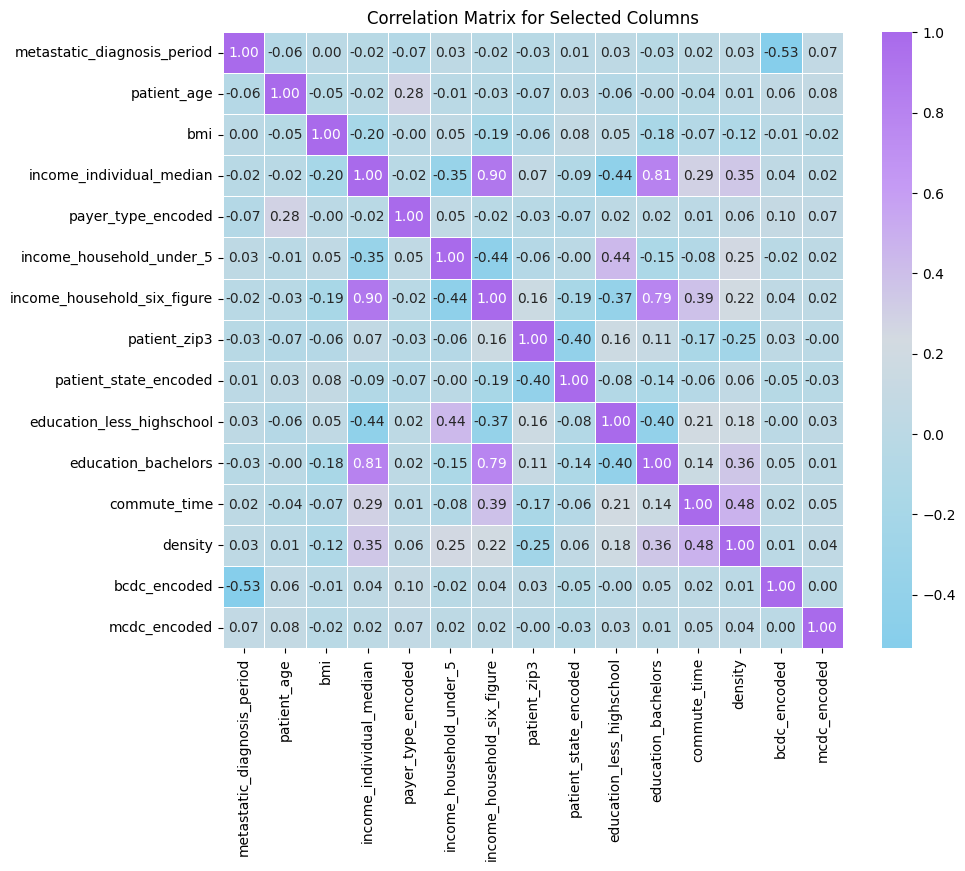

In [39]:
selected_columns = [
    'metastatic_diagnosis_period','patient_age', 'bmi', 'income_individual_median','payer_type_encoded',
    'income_household_under_5','income_household_six_figure','patient_zip3','patient_state_encoded',
    'education_less_highschool','education_bachelors','commute_time','density', 'bcdc_encoded','mcdc_encoded'
]

# Create a new DataFrame with only the selected columns
subset_df = train_df[selected_columns]

# Calculate the correlation matrix for the selected columns
correlation_matrix = subset_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=custom_cmap, linewidths=0.5)
plt.title('Correlation Matrix for Selected Columns')
plt.show()

## Modeling 

**Prepare and split the data into train and test datasets**

In [23]:
# Extract features and target variable
selected_features = [
    'patient_age', 'patient_race_encoded', 'payer_type_encoded', 'income_individual_median', 'Region_encoded',
    'income_household_under_5', 'income_household_six_figure', 'patient_zip3', 'education_less_highschool', 
    'education_bachelors', 'density', 'bcdc_encoded', 'mcdc_encoded'
]

X = train_df[selected_features]
y = train_df['metastatic_diagnosis_period']

# Prepare the test data
X_test = test_df[selected_features]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

**CatBoost Regressor**

In [39]:
# Train the CatBoost model
# Initialize CatBoostRegressor
cbt_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=10,
    eval_metric='RMSE',
    random_seed=42,
    logging_level='Verbose',
    od_type='Iter',
    od_wait=50
)

# Train the model
cbt_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True, verbose=True)

# Evaluate the model on the validation set
val_predictions = cbt_model.predict(X_val)
val_rmse = mean_squared_error(y_val, val_predictions, squared=False)
print("Validation RMSE:", val_rmse)


# Retrain on the full training data
cbt_model.fit(X, y)

# Make predictions on the test set
predictions = cbt_model.predict(X_test)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)
predictions[predictions < 0] = 0  # Set negative predictions to 0


# Save the predictions to a file
ctb_submission = pd.DataFrame({
    'patient_id': test_df.index,
    'metastatic_diagnosis_period': predictions
})

ctb_submission.to_csv('ctb_submission.csv', index=False)

0:	learn: 104.3199019	test: 105.6406172	best: 105.6406172 (0)	total: 3.31ms	remaining: 3.31s
1:	learn: 100.8459318	test: 102.1205276	best: 102.1205276 (1)	total: 25.8ms	remaining: 12.9s
2:	learn: 97.7723873	test: 98.9058144	best: 98.9058144 (2)	total: 45.2ms	remaining: 15s
3:	learn: 95.1649876	test: 96.1587909	best: 96.1587909 (3)	total: 65.7ms	remaining: 16.4s
4:	learn: 93.0223620	test: 93.9199107	best: 93.9199107 (4)	total: 85.5ms	remaining: 17s
5:	learn: 91.1009132	test: 92.0570488	best: 92.0570488 (5)	total: 105ms	remaining: 17.4s
6:	learn: 89.5182543	test: 90.4554050	best: 90.4554050 (6)	total: 125ms	remaining: 17.7s
7:	learn: 88.1380399	test: 89.1624987	best: 89.1624987 (7)	total: 144ms	remaining: 17.8s
8:	learn: 86.9288020	test: 88.0166913	best: 88.0166913 (8)	total: 163ms	remaining: 17.9s
9:	learn: 85.8696076	test: 87.0336611	best: 87.0336611 (9)	total: 183ms	remaining: 18.1s
10:	learn: 85.0193167	test: 86.2499829	best: 86.2499829 (10)	total: 201ms	remaining: 18.1s
11:	learn: 8

C:\Users\Zuhal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6:	learn: 89.4394324	total: 134ms	remaining: 19s
7:	learn: 88.0828678	total: 154ms	remaining: 19.1s
8:	learn: 86.8995555	total: 176ms	remaining: 19.4s
9:	learn: 85.8515636	total: 198ms	remaining: 19.6s
10:	learn: 85.0022666	total: 221ms	remaining: 19.8s
11:	learn: 84.1742892	total: 242ms	remaining: 19.9s
12:	learn: 83.5154165	total: 264ms	remaining: 20.1s
13:	learn: 82.8670077	total: 286ms	remaining: 20.1s
14:	learn: 82.3610021	total: 307ms	remaining: 20.2s
15:	learn: 81.9159832	total: 329ms	remaining: 20.2s
16:	learn: 81.4534579	total: 350ms	remaining: 20.3s
17:	learn: 81.1049727	total: 372ms	remaining: 20.3s
18:	learn: 80.8087140	total: 394ms	remaining: 20.3s
19:	learn: 80.5188645	total: 416ms	remaining: 20.4s
20:	learn: 80.2649068	total: 437ms	remaining: 20.4s
21:	learn: 79.9844208	total: 458ms	remaining: 20.4s
22:	learn: 79.7451940	total: 480ms	remaining: 20.4s
23:	learn: 79.4608772	total: 501ms	remaining: 20.4s
24:	learn: 79.2608601	total: 522ms	remaining: 20.4s
25:	learn: 79.0713

**LightGBM Regressor**

In [38]:
# Determine num_leaves based on max_depth
num_leaves = 2**10 - 1  # For max_depth=10

# Initialize LightGBM model
lgb_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=10,
    num_leaves=num_leaves,  # Setting num_leaves
    objective='regression',
    random_state=42
)

# Train the model
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')

# Evaluate the model on the validation set
val_predictions = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration_)
val_rmse = mean_squared_error(y_val, val_predictions, squared=False)
print("Validation RMSE:", val_rmse)

# Retrain on the full training data
lgb_model.fit(X, y)

# Make predictions on the test set
predictions = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)
predictions[predictions < 0] = 0  # Set negative predictions to 0


# Save the predictions to a file
gbm_submission = pd.DataFrame({
    'patient_id': test_df.index,
    'metastatic_diagnosis_period': predictions
})

# gbm_submission.to_csv('gbm_submission.csv', index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1893
[LightGBM] [Info] Number of data points in the train set: 10538, number of used features: 13
[LightGBM] [Info] Start training from score 95.746631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\Zuhal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Validation RMSE: 93.12026237488044
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1903
[LightGBM] [Info] Number of data points in the train set: 13173, number of used features: 13
[LightGBM] [Info] Start training from score 96.515221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

**XGBoost Regressor**

In [37]:
# Train the XGBoost model
# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=10,
    eval_metric='rmse',
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train, 
          early_stopping_rounds=50, 
          eval_set=[(X_val, y_val)], 
          verbose=True)

# Evaluate the model on the validation set
val_predictions = xgb_model.predict(X_val)

val_rmse = mean_squared_error(y_val, val_predictions, squared=False)
print("Validation RMSE:", val_rmse)

# Retrain on the full training data
xgb_model.fit(X, y)

# Make predictions on the test set
predictions = xgb_model.predict(X_test)

# Convert predictions to integers and handle negative values
predictions = np.round(predictions).astype(int)
predictions[predictions < 0] = 0  # Set negative predictions to 0


# Save the predictions to a file
xgb_submission = pd.DataFrame({
    'patient_id': test_df.index,
    'metastatic_diagnosis_period': predictions
})

# xgb_submission.to_csv('xgb_submission.csv', index=False)

[0]	validation_0-rmse:105.70414
[1]	validation_0-rmse:101.77806
[2]	validation_0-rmse:98.42995
[3]	validation_0-rmse:95.64363
[4]	validation_0-rmse:93.33743
[5]	validation_0-rmse:91.45492
[6]	validation_0-rmse:90.01988
[7]	validation_0-rmse:88.73142
[8]	validation_0-rmse:87.72388
[9]	validation_0-rmse:86.99773
[10]	validation_0-rmse:86.25309
[11]	validation_0-rmse:85.69910
[12]	validation_0-rmse:85.29221
[13]	validation_0-rmse:84.84737
[14]	validation_0-rmse:84.57993
[15]	validation_0-rmse:84.33367


C:\Users\Zuhal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-rmse:84.17361
[17]	validation_0-rmse:84.02895
[18]	validation_0-rmse:83.90695
[19]	validation_0-rmse:83.84803
[20]	validation_0-rmse:83.79855
[21]	validation_0-rmse:83.75917
[22]	validation_0-rmse:83.76324
[23]	validation_0-rmse:83.75140
[24]	validation_0-rmse:83.83100
[25]	validation_0-rmse:83.83890
[26]	validation_0-rmse:83.79571
[27]	validation_0-rmse:83.82270
[28]	validation_0-rmse:83.80991
[29]	validation_0-rmse:83.85070
[30]	validation_0-rmse:83.85546
[31]	validation_0-rmse:83.88288
[32]	validation_0-rmse:83.89583
[33]	validation_0-rmse:83.97442
[34]	validation_0-rmse:84.01247
[35]	validation_0-rmse:84.10002
[36]	validation_0-rmse:84.07273
[37]	validation_0-rmse:84.08482
[38]	validation_0-rmse:84.11158
[39]	validation_0-rmse:84.16708
[40]	validation_0-rmse:84.22774
[41]	validation_0-rmse:84.28127
[42]	validation_0-rmse:84.31386
[43]	validation_0-rmse:84.40580
[44]	validation_0-rmse:84.42896
[45]	validation_0-rmse:84.54950
[46]	validation_0-rmse:84.64391
[47]	val

C:\Users\Zuhal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Model Evaluation**

In [27]:
# Initialize models
models = {
    "CatBoost": cbt_model,
    "LightGBM": lgb_model,
    "XGBoost": xgb_model
}

# Dictionary to store evaluation results
results = {"Model": [], "RMSE": [], "MAE": []}

# Evaluate each model
for model_name, model in models.items():
    # Predict on validation set
    val_predictions = model.predict(X_val)
    
    # Calculate evaluation metrics
    rmse = mean_squared_error(y_val, val_predictions, squared=False)
    mae = mean_absolute_error(y_val, val_predictions)
    
    # Store results
    results["Model"].append(model_name)
    results["RMSE"].append(rmse)
    results["MAE"].append(mae)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)

C:\Users\Zuhal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Zuhal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Zuhal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mea

      Model       RMSE        MAE
0  CatBoost  36.377193  25.454163
1  LightGBM  22.457098  14.599492
2   XGBoost   7.396125   1.428036


**Distribution of the ***`predicted`*** metastatic_diagnosis_period**
- CatBoost result

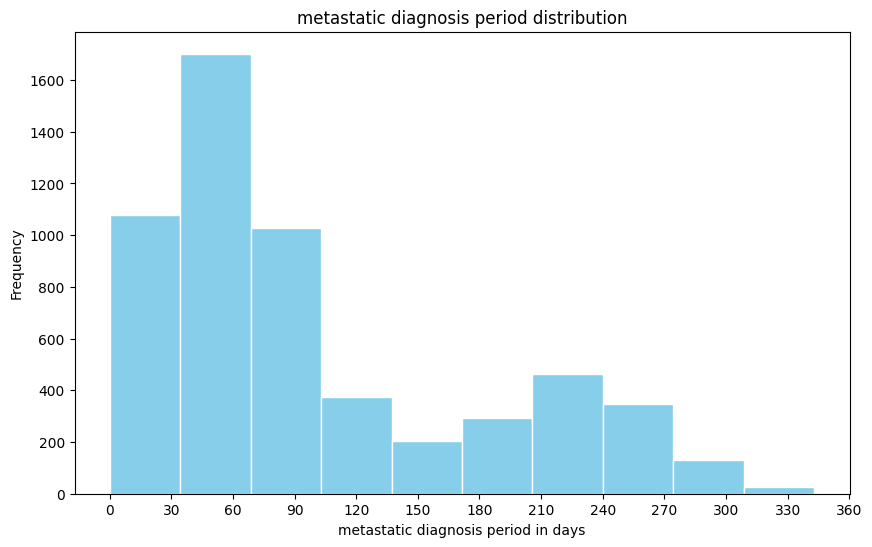

In [40]:
# Distribution of metastatic_diagnosis_period

plt.figure(figsize=(10, 6))
ctb_submission['metastatic_diagnosis_period'].plot(kind='hist', color='SkyBlue', edgecolor='white')
plt.title('metastatic diagnosis period distribution')
plt.xlabel('metastatic diagnosis period in days')

max_value = ctb_submission['metastatic_diagnosis_period'].max()
# Set x-axis ticks
plt.xticks(np.arange(0, max_value + 30, 30))

plt.show()

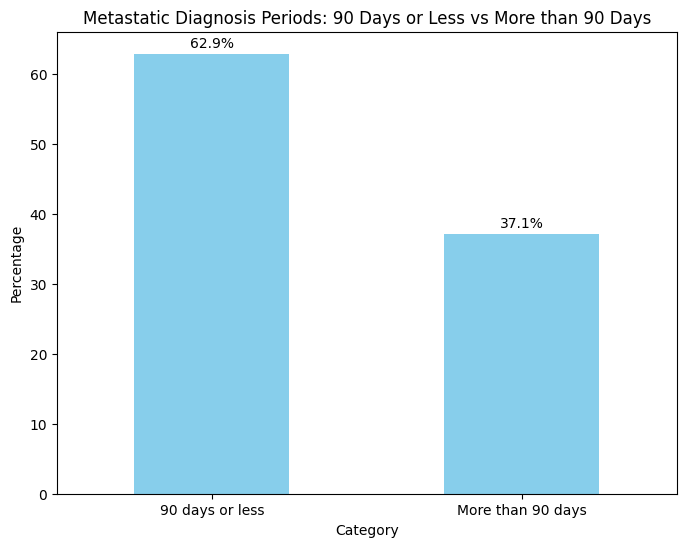

In [41]:
# Calculate percentages directly
total = len(ctb_submission)
percentages = (ctb_submission['metastatic_diagnosis_period'] <= 90).value_counts(normalize=True) * 100

# Plot the counts of each category with percentage labels
plt.figure(figsize=(8, 6))
ax = percentages.plot(kind='bar', color='skyblue')

# Add percentage labels on top of each bar
for i, percentage in enumerate(percentages):
    plt.text(i, percentage + 0.5, f"{percentage:.1f}%", ha='center', va='bottom')

plt.title('Metastatic Diagnosis Periods: 90 Days or Less vs More than 90 Days')
plt.xlabel('Category')
plt.ylabel('Percentage')

# Add custom text to x-axis ticks
plt.xticks(ticks=[0, 1], labels=['90 days or less', 'More than 90 days'], rotation=0)

plt.show()